# Data Modelling

In [2]:
import pandas as pd
data = pd.read_csv('../data/processed/loan_data_processed.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   float64
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(7), int64(6), object(1)
memory usage: 1.0+ MB


In [4]:
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,6.721546,11.350407,19.48,737,2.800443,10.270039,52.1,0,0,0,0
1,1,credit_card,0.1071,5.434682,11.082143,14.29,707,2.147292,10.422995,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,5.907702,10.373491,11.63,682,2.632184,8.163941,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,5.095834,11.350407,8.10,712,2.127892,10.424303,73.2,1,0,0,0
4,1,credit_card,0.1426,4.643621,11.299732,14.97,667,2.496483,8.464003,39.5,0,1,0,0


In [5]:
X = data.drop('not.fully.paid', axis=1)
y = data['not.fully.paid']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [7]:
numeric_features = [
    'int.rate', 'installment', 'log.annual.inc', 'dti',
    'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
    'inq.last.6mths', 'delinq.2yrs', 'pub.rec'
]

categorical_features = ['purpose']

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        ))
    ]
)

In [11]:
log_reg_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['int.rate', 'installment',
                                                   'log.annual.inc', 'dti',
                                                   'fico', 'days.with.cr.line',
                                                   'revol.bal', 'revol.util',
                                                   'inq.last.6mths',
                                                   'delinq.2yrs', 'pub.rec']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['purpose'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [12]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = log_reg_model.predict(X_test)
y_proba = log_reg_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.89      0.64      0.74      1609
           1       0.24      0.58      0.33       307

    accuracy                           0.63      1916
   macro avg       0.56      0.61      0.54      1916
weighted avg       0.78      0.63      0.68      1916

ROC-AUC: 0.6716839115480309


Brier score (calibrated): 0.1272433093930824


c:\Users\omara\anaconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


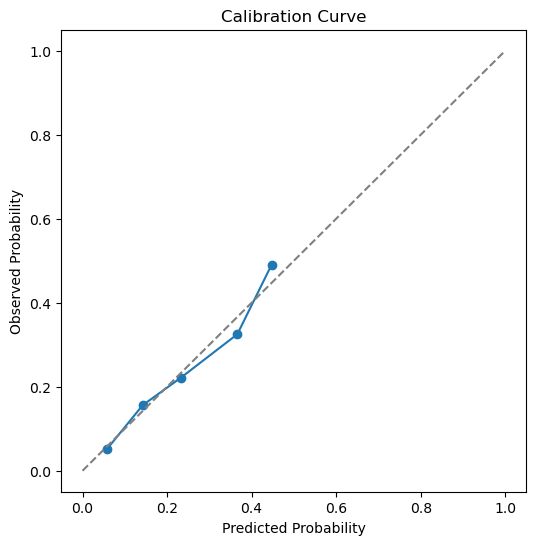

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Wrap your existing logistic regression in calibration
calibrated_model = CalibratedClassifierCV(
    estimator=log_reg_model.named_steps['classifier'],
    method='isotonic',  # or 'sigmoid' for Platt
    cv='prefit'          # already trained
)

# Preprocess train/test first
X_train_preprocessed = log_reg_model.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed  = log_reg_model.named_steps['preprocessor'].transform(X_test)

# Fit calibrated model on training data
calibrated_model.fit(X_train_preprocessed, y_train)

# Predict probabilities on test set
y_proba_cal = calibrated_model.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate Brier score (probability quality)
print("Brier score (calibrated):", brier_score_loss(y_test, y_proba_cal))

# Plot calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_cal, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.title("Calibration Curve")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.show()


## Saving the Model

In [18]:
import pickle

# Save the entire calibrated pipeline
with open("../models/loan_default_model.pkl", "wb") as f:
    pickle.dump(calibrated_model, f)